### Determinantal Point Process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded.")

Packages loaded.


### Util

In [2]:
def get_color_2d(x):
    c = np.concatenate((x[:,0:1],x[:,1:2]),axis=1)
    c = (c-np.min(x,axis=0))/(np.max(x,axis=0)-np.min(x,axis=0))
    r,g,b = 1.0-c[:,1:2],c[:,0:1],0.5-np.zeros_like(c[:,0:1])
    c = np.concatenate((r,g,b),axis=1)
    return c

def grid_2d(x0_min,x0_max,x1_min,x1_max,n_x0,n_x1):
    x0s,x1s = np.meshgrid(np.arange(x0_min,x0_max,(x0_max-x0_min)/n_x0),
                          np.arange(x1_min,x1_max,(x1_max-x1_min)/n_x1))
    x = np.dstack([x0s,x1s]).reshape(-1,2) 
    return x
print ("Done.")

Done.


### k-DPP

In [3]:
def get_dpp_subset_from_K(K,n_sel):
    n_total     = K.shape[0]
    remain_idxs = np.arange(n_total)
    sub_idx     = np.zeros((n_sel))
    sum_K_vec   = np.zeros(n_total)
    for i_idx in range(n_sel):
        if i_idx == 0:
            sel_idx = np.random.randint(n_total) # random first
        else:
            curr_K_vec = K[(int)(sub_idx[i_idx-1]),:] 
            sum_K_vec  = sum_K_vec + curr_K_vec
            k_vals     = sum_K_vec[remain_idxs]
            min_idx    = np.argmin(k_vals)
            sel_idx    = remain_idxs[min_idx] 
        sub_idx[i_idx] = (int)(sel_idx)
        remain_idxs = np.delete(remain_idxs,np.argwhere(remain_idxs==sel_idx))
    sub_idx = sub_idx.astype(np.int32) # make it int
    return sub_idx

def get_dpp_subset(x,n_sel,alpha=1000):
    D = distance.cdist(x,x,'sqeuclidean') 
    K = np.exp(-alpha*D)
    sub_idx = get_dpp_subset_from_K(K,n_sel)
    x_sel = x[sub_idx,:] 
    return x_sel,sub_idx

def get_rand_subset(x,n_sel):
    n_total = x.shape[0]
    sub_idx = np.random.permutation(n_total)[:n_sel]
    x_sel = x[sub_idx,:] 
    return x_sel,sub_idx

print ("Done.")

Done.


### Random vs. DPP sampling from a uniform set

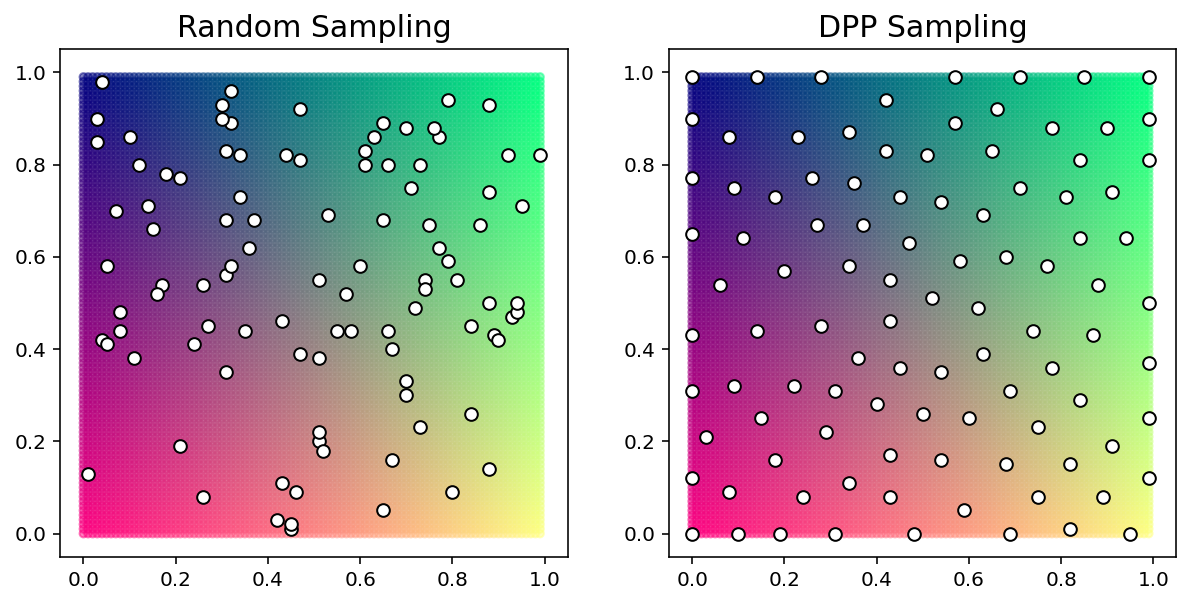

In [4]:
x = grid_2d(0,1,0,1,100,100)
c = get_color_2d(x)
n_sel = 100
x_dpp,idx_dpp = get_dpp_subset(x,n_sel=n_sel)
x_rand,idx_rand = get_rand_subset(x,n_sel=n_sel)
c_dpp,c_rand = c[idx_dpp,:],c[idx_rand,:]

# Plot 
am,ma,ms,ms2 = 0.05,0.5,15,40
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(x[:,0],x[:,1],c=c,edgecolors=c,s=ms,marker='o',alpha=ma)
plt.scatter(x_rand[:,0],x_rand[:,1],c='w',edgecolors='k',s=ms2,marker='o',alpha=1.0)
plt.title("Random Sampling",fontsize=15)
plt.axis('square')
plt.axis([0-am,1+am,0-am,1+am])
plt.subplot(122)
plt.scatter(x[:,0],x[:,1],c=c,edgecolors=c,s=ms,marker='o',alpha=ma)
plt.scatter(x_dpp[:,0],x_dpp[:,1],c='w',edgecolors='k',s=ms2,marker='o',alpha=1.0)
plt.axis('square')
plt.title("DPP Sampling",fontsize=15)
plt.axis([0-am,1+am,0-am,1+am])
plt.show()

### Random vs. DPP sampling from an imbalance set

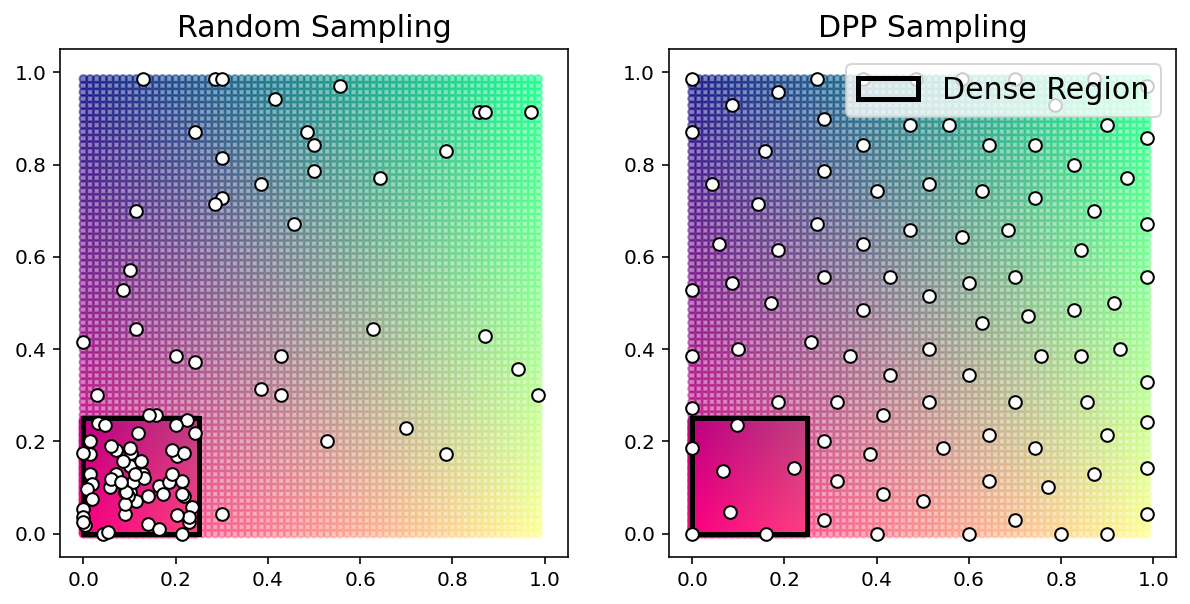

In [6]:
x = np.concatenate((grid_2d(0,1,0,1,70,70),
                    grid_2d(0,1/4,0,1/4,70,70)),axis=0)
c = get_color_2d(x)
n_sel = 100
x_dpp,idx_dpp = get_dpp_subset(x,n_sel=n_sel)
x_rand,idx_rand = get_rand_subset(x,n_sel=n_sel)
c_dpp,c_rand = c[idx_dpp,:],c[idx_rand,:]

# Plot 
am,ma,ms,ms2 = 0.05,0.5,15,40
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(x[:,0],x[:,1],c=c,edgecolors=c,s=ms,marker='o',alpha=ma)
rect = plt.Rectangle(xy=(0,0),width=1/4,height=1/4,fill=False,edgecolor='k',linewidth=2.5)
plt.gca().add_patch(rect)
plt.scatter(x_rand[:,0],x_rand[:,1],c='w',edgecolors='k',s=ms2,marker='o',alpha=1.0)
plt.title("Random Sampling",fontsize=15)
plt.axis('square')
plt.axis([0-am,1+am,0-am,1+am])
plt.subplot(122)
plt.scatter(x[:,0],x[:,1],c=c,edgecolors=c,s=ms,marker='o',alpha=ma)
rect = plt.Rectangle(xy=(0,0),width=1/4,height=1/4,fill=False,edgecolor='k',linewidth=2.5,
                    label='Dense Region')
plt.gca().add_patch(rect)
plt.scatter(x_dpp[:,0],x_dpp[:,1],c='w',edgecolors='k',s=ms2,marker='o',alpha=1.0)
plt.axis('square')
plt.title("DPP Sampling",fontsize=15)
plt.axis([0-am,1+am,0-am,1+am])
plt.legend(loc='upper right',fontsize=15)
plt.show()